In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.util.shape import view_as_blocks
from skimage import io, transform
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPool2D
from random import shuffle
from glob import glob
import tqdm
import os
import re
import warnings
warnings.filterwarnings('ignore')

2023-07-30 15:19:18.759266: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# DATA INPUT

In [13]:
train_count = 5000
test_count = 1000

train = glob("./dataset/train/*.jpeg")
test = glob("./dataset/test/*.jpeg")

shuffle(train)
shuffle(test)

train = train[:train_count]
test = test[:test_count]

# piece symbols to be used in FEN definitions
piece_symbols = 'prbnkqPRBNKQ'

In [14]:
train[4]

'/Users/loicsteve/Desktop/EPITA/Semester 3/Computer Vision/AI Chess Master/archive/dataset/train/qN2n3-Br6-8-1K3b2-8-PQ4q1-5k2-2q3Q1.jpeg'

# Function to extract FEN from filename

In [35]:
def fen_from_file(filename):
    base = os.path.basename(filename)
    return os.path.splitext(base)[0]

# Fen Samples

In [16]:
print(fen_from_file(train[0]), '\n', fen_from_file(train[1]), '\n', fen_from_file(train[2]))

3N4-8-r7-1N2Krn1-8-8-5k2-8 
 2Q3B1-6P1-5K1P-7p-4rkP1-5q2-8-r3r3 
 8-4qN2-8-p7-2K3n1-1N6-3Pk3-8


# Plot Samples

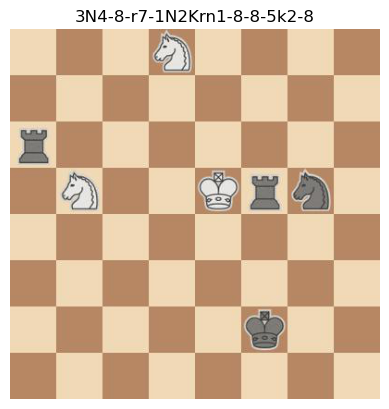

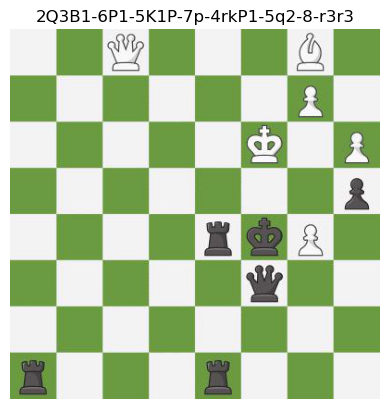

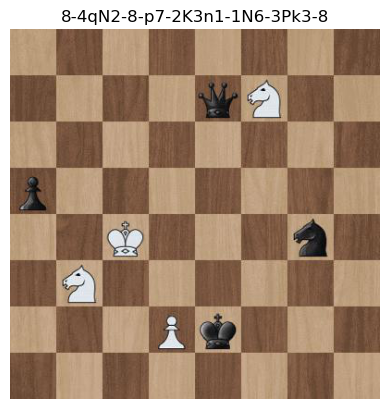

In [17]:
for i in range(0,3):
    plt.title(fen_from_file(train[i]))
    plt.imshow(mpimg.imread(train[i]))
    plt.axis('off')
    plt.show()

# Functions to convert FEN to one-hot encoded vectors 

In [18]:
# images to array
def images(images_path, image_height, image_width):
    image_list = []

    for image in tqdm(os.listdir(images_path)):
        path = os.path.join(images_path, image)

        image = cv2.imread(path)
        image = cv2.resize(image , (image_height, image_width))
        image_list.append([np.array(image)])
    
    shuffle(image_list)

    array_image = np.array(image_list)

    images = array_image[:,0,:,:]

    return(images)

In [19]:
def onehot_from_fen(fen):
    eye = np.eye(NB_CLASSES)
    output = np.empty((0, NB_CLASSES))
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(
              output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, NB_CLASSES)), axis=0)

    return output

def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

# Function to proccess an image:
-  downsample an image to 200 by 200 pixel
-  split an image of the chess board to 64 images of individual squares
-  drop redundant dimensions, reshape

In [20]:
# downsample images - split to chess board squares - flatten and reshape
def process_image(img):
    downsample_size = 200
    square_size = int(downsample_size/8)
    img_read = io.imread(img)
    img_read = transform.resize(
      img_read, (downsample_size, downsample_size), mode='constant')
    tiles = view_as_blocks(img_read, block_shape=(square_size, square_size, 3))
    tiles = tiles.squeeze(axis=2)

    return tiles.reshape(64, square_size, square_size, 3)

# Functions for sampling batches for training and evaluation:

In [21]:
def train_gen(features):
    for _, img in enumerate(features):
        y = onehot_from_fen(fen_from_file(img))
        x = process_image(img)
        yield x, y

def pred_gen(features, batch_size):
    for i, img in enumerate(features):
        yield process_image(img)

# the model

In [22]:
# Set training parameters
img_rows = 25
img_cols = 25
EPOCHS = 100
BATCH_SIZE = 8
NB_CLASSES = 13

In [26]:
model = Sequential()
# Convolutional 2D layer
model.add(Conv2D(15, kernel_size=2, activation='relu', 
          input_shape=(img_rows, img_cols, 3)))
# Pooling operation
model.add(MaxPool2D(2))
# Add another convolutional layer
model.add(Conv2D(5, kernel_size=2, activation='relu'))
# Flatten and feed to output layer
model.add(Flatten())
# Add a dropout layer
model.add(Dropout(0.3))
# Output layer
model.add(Dense(13, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 15)        195       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 15)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 5)         305       
                                                                 
 flatten (Flatten)           (None, 605)               0         
                                                                 
 dropout (Dropout)           (None, 605)               0         
                                                                 
 dense (Dense)               (None, 13)                7878      
                                                      

In [27]:
# Compile the model 
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model

In [28]:
# Fit params
history = model.fit_generator(
    train_gen(train), steps_per_epoch=len(train)//EPOCHS,
    epochs=EPOCHS, verbose=1, validation_data=train_gen(test),
    validation_steps=len(test)//EPOCHS
)

Epoch 1/100
50/50 [==============================] - 4s 42ms/step - loss: 1.1536 - accuracy: 0.7934 - val_loss: 0.8986 - val_accuracy: 0.8359
Epoch 2/100
50/50 [==============================] - 2s 40ms/step - loss: 0.8126 - accuracy: 0.8497 - val_loss: 0.7205 - val_accuracy: 0.8328
Epoch 3/100
50/50 [==============================] - 3s 65ms/step - loss: 0.6233 - accuracy: 0.8522 - val_loss: 0.5568 - val_accuracy: 0.8531
Epoch 4/100
50/50 [==============================] - 2s 43ms/step - loss: 0.4615 - accuracy: 0.8741 - val_loss: 0.4661 - val_accuracy: 0.8687
Epoch 5/100
50/50 [==============================] - 2s 39ms/step - loss: 0.3208 - accuracy: 0.9184 - val_loss: 0.3332 - val_accuracy: 0.9250
Epoch 6/100
50/50 [==============================] - 2s 34ms/step - loss: 0.2651 - accuracy: 0.9256 - val_loss: 0.3168 - val_accuracy: 0.9234
Epoch 7/100
50/50 [==============================] - 2s 33ms/step - loss: 0.1889 - accuracy: 0.9528 - val_loss: 0.1515 - val_accuracy: 0.9609
Epoch 

# Performance Evaluation

In [29]:
res = (
    model.predict_generator(pred_gen(test, 64), steps=test_count)
    .argmax(axis=1)
    .reshape(-1, 8, 8)
)

In [30]:
pred_fens = np.array([fen_from_onehot(one_hot) for one_hot in res])
test_fens = np.array([fen_from_file(fn) for fn in test])

final_accuracy = (pred_fens == test_fens).astype(float).mean()

print("Accuracy: {:2f}".format(final_accuracy))

Accuracy: 0.925000


In [31]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


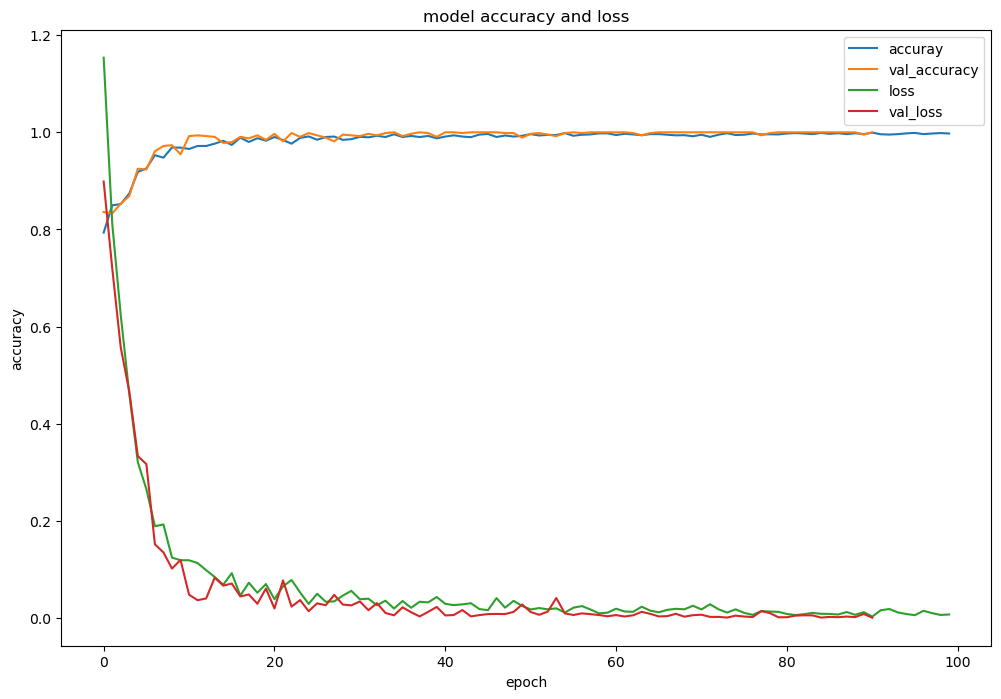

In [32]:
fig = plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy and loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuray', 'val_accuracy', 'loss', 'val_loss'], loc='upper right')
plt.show()

# Sample image prediction

In [33]:
def predicted_fen_plot(image):
    pred = model.predict(process_image(image)).argmax(axis=1).reshape(-1, 8, 8)
    fen = fen_from_onehot(pred[0])
    imgplot = plt.imshow(mpimg.imread(image))
    plt.axis('off')
    plt.title(fen)
    plt.show()

2/2 [==============================] - 0s 7ms/step


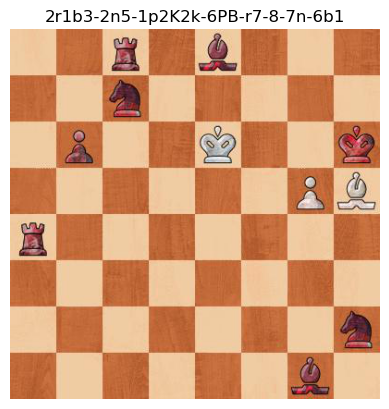

2/2 [==============================] - 0s 8ms/step


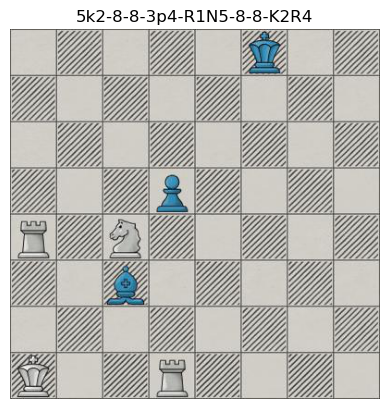

2/2 [==============================] - 0s 4ms/step


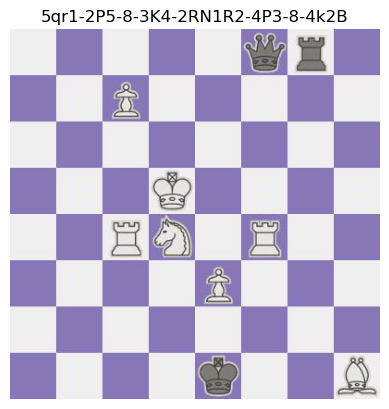

None None None


In [34]:
print(predicted_fen_plot(test[0]), predicted_fen_plot(test[1]), predicted_fen_plot(test[2]))